# Analyze Capping Levels

## The Big

Large individual losses are highly likely to be high-leverage outliers. This makes them particularly problematic when creating a pricing model that is meant to generalize to unseen data.

We could remove the large loss observations. That would probably fix the generalization problems, but claims are rare enough! It feels bad to remove perfectly realistic observations for no good reason other than they were big!

I propose using a capping procedure instead. I hypothesize that if we were to train a model on completely uncapped losses, it would generalize to unseen data poorly. If we were to cap large losses a little bit, it would improve generalization. Capping more would continue to improve generalization until it hits some sort of optimum generalization capability. Then, capping becomes problematic- it starts to remove useful information about claim size that helps the model generlize. Can you imagine the U-shape I am describing? 

This implies there is an "optimal" capping level that gives us the best generalization capability- not too much cap and not too little cap. I'll try to find that optimal capping level here in this document.

## The Small

I mentioned in the descriptive analysis that there are some observations with 0 or very small exposures. These are also problematic, especially if they have a claim. Imagine an observation with an exposure like 0.01 and a loss of 100,000. The pure premium would be 10,000,000! The model is going to react to that large target value, but it shouldn't- the exposure is only 0.01...this particular risk was just supremely unlucky to have a claim in the super short time it was insured.

Once again, I have a hypothesis that using some sort of floor to exclude risks with very small exposure is a good idea. But set that floor too high and suddenly we're removing valuable observations. Once again, this implies an optimal minimum exposure cutoff. I'll try to find that optimal minimum exposure cutoff here in this document as well.

## Combining Concepts

Because small exposure amounts cause large pure premium amounts, these two parameters (large loss cap and minimum exposure) are going to interact with each other. I'll need to tune the two of them together. 

I'll approach this problem as one would normally tune hyperparameters- in fact, I'm now going to treat these two parameters like hyperparameters for my models.

# Packages & Settings

In [13]:
import pandas as pd
import numpy as np

from joblib import Parallel, delayed
from pathlib import Path
from utils import *

# Import Data

In [14]:
df = pd.read_parquet("data/df_train.parquet") # remember- just the training data

# Cross-validation Folds Definitions

As part of this "generalization" assessment, I'll be utilizing cross-validation. As part of cross-validation, subsets of the dataset are created (aka "folds"). A model is trained on all but 1 fold, then a prediction is recorded for the holdout fold. Then a new model is training excluding the next fold, then a prediction is recorded for *that* fold. Repeat until all the folds have been held out. I then have an "out of sample" prediction for every single observation in the dataset.

I'll be doing this cross-validation technique 1 time for every combination of the large loss cap and small exposure filter I consider. That's going to be a lot of cross-validation. It will be helpful for my analysis for the random subsetting to be consistent from scenario to scenario. Additionally, I'd appreciate the folds being stratified, just like our stratification of the train and test split. These requirements aren't baked into some of the pre-defined functions I'll use later. Instead, I'll define the folds up front one time now and rely on that fold index later.

In [15]:
fold_id_train, cv_iterable, fold_summary = make_pf_balanced_group_folds(
    df, n_splits=5, bins=10, tol=0.002, max_tries=300, random_state=42
)
display(fold_summary)
df["fold_id"] = fold_id_train

CV folds seed: 51 | PF spread across folds: 0.001820 (tol=0.002)


,fold,exposure,claims,portfolio_freq
0,0,57450.674146,5734,0.099807
1,1,57544.132173,5764,0.100167
2,2,57406.954792,5803,0.101085
3,3,57209.206263,5814,0.101627
4,4,57276.335447,5751,0.100408


# Initial Model Parameterization

First, the Xs:

In [16]:
all_cols = [
  'Area',
  'VehPower',
  'VehAge',
  'DrivAge',
  'BonusMalus',
  'VehBrand',
  'VehGas',
  'Density',
  'Region'
]

num_cols = list(df[all_cols].select_dtypes(include=[np.number]).columns)
cat_cols = list(df[all_cols].select_dtypes(exclude=[np.number]).columns)
print(f"Numerics: {len(num_cols)} | Categoricals: {len(cat_cols)}")

Numerics: 5 | Categoricals: 4


And now the Ys.

I am trying to choose between different target variables, training models for every scenario (see above explanation). In order to do this, I'll be training a Tweedie model. One of the parameters necessary for fitting a Tweedie model is the power parameter ([more info](https://en.wikipedia.org/wiki/Tweedie_distribution)). For our data, tt takes on values between 1 and 2. It is almost certainly going to vary as the large loss cap changes. I need to estimate what this parameter is for each capping scenario.

I'll do this using profiling. In short, I'll be using maximum likelihood estimation given a feature list. It's a little difficult- all of these things are a little interdependent but I'm still trying to finalize one thing at a time. One nice thing about Tweedie power is that it usually has very little influence on the final fit coefficients. In practice, one thing I like to do is try all this up front, go through the entire process and then go back and just *verify* that my decisions wouldn't change dramatically.

WARNING: This next block takes a very long time to run. On my machine, I used 3 cores, it nearly maxed out on memory and it will took around 40 minutes to run fully. As such, I've added manual triggers to avoid running it multiple times.

In [ ]:
N_JOBS = 3
FROM_BACKUP = True

caps = [1, 10_000, 25_000, 50_000, 100_000, 200_000, 300_000,
        400_000, 500_000, 600_000, 700_000, 800_000, 900_000,
        1_000_000, 2_000_000]
thresholds = [0.01, 0.05, 1/12, 1/6]

if (not FROM_BACKUP) or (not Path("data/capping_levels/p_hat_grid.parquet").exists()): 
    results = Parallel(n_jobs=N_JOBS, backend="loky")(
        delayed(phat_for_combo)(thr, cap, df, num_cols) for thr in thresholds for cap in caps
    )

    p_hat_grid = pd.DataFrame(results).sort_values(
        ["min_exposure_threshold", "cap"]
    ).reset_index(drop=True)

    p_hat_grid.to_parquet("data/capping_levels/p_hat_grid.parquet")
else:
    p_hat_grid = pd.read_parquet("data/capping_levels/p_hat_grid.parquet")


Great! Now I have an estimate of p_hat to use when fitting a model with each combination of capping level and minimum exposure.

In [23]:
p_hat_grid

,cap,min_exposure_threshold,p_hat
0,1,0.010000,1.37
1,10000,0.010000,1.76
2,25000,0.010000,1.83
3,50000,0.010000,1.87
4,100000,0.010000,1.91
5,200000,0.010000,1.93
6,300000,0.010000,1.94
7,400000,0.010000,1.94
8,500000,0.010000,1.94
9,600000,0.010000,1.94


# Cross-validation for Each Combination

Now we will move into determining which capping/flooring set is the "best." I'll do that by determining which cap and minimum exposure threshold that we train on produces the best out of sample fit to uncapped and unfiltered pure premium.

WARNING: Once again, this isn't the most efficient implementation of this logic, so it can take a bit. It doesn't take nearly as long as the above code block, but I stuck a FROM_BACKUP parameter on it just the same.

In [ ]:
FROM_BACKUP = True
uncapped_p_hat = p_hat_grid["p_hat"].iloc[59]

if (not FROM_BACKUP) or (not Path("data/capping_levels/cv_dev.parquet").exists()): 
    # ---- loop over all rows in p_hat_grid and collect mean deviance
    records = []
    for row in p_hat_grid.itertuples(index=False):
        cap = row.cap
        min_exp = row.min_exposure_threshold
        p_hat = row.p_hat

        mean_dev = evaluate_scenario(cap, min_exp, p_hat, df, num_cols, uncapped_p_hat)
        records.append({
            "cap": cap,
            "min_exposure_threshold": min_exp,
            "mean_dev_fold": mean_dev
        })

    cv_dev = pd.DataFrame(records)
    cv_dev.to_parquet("data/capping_levels/cv_dev.parquet")
else:
    cv_dev = pd.read_parquet("data/capping_levels/cv_dev.parquet")

Awesome!

Now we have a table that tells us the mean Tweedie deviance for each capping scenario. This tells us how well that particular parameterization predicts out of sample uncapped losses.

Let's take a look:

In [20]:
cv_dev.sort_values("mean_dev_fold").head(10)
best_cap = cv_dev.sort_values("mean_dev_fold")["cap"].iloc[0]
best_min_exposure_threshold = cv_dev.sort_values("mean_dev_fold")["min_exposure_threshold"].iloc[0]

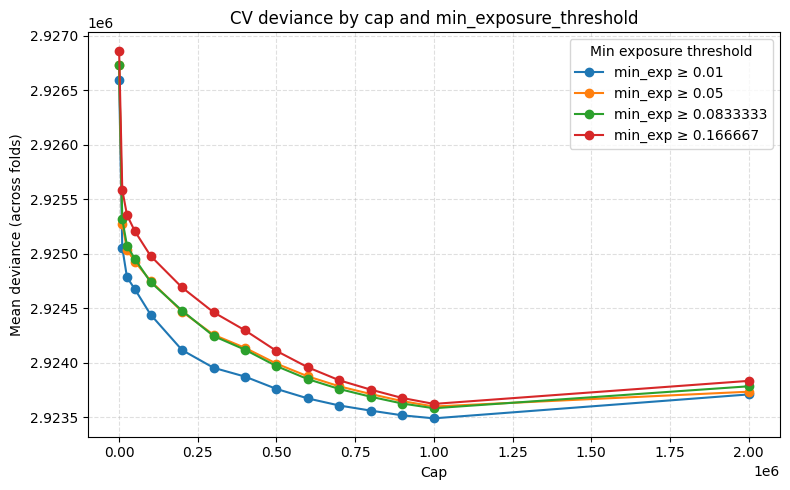

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

for met, grp in cv_dev.groupby("min_exposure_threshold"):
    g = grp.sort_values("cap")
    ax.plot(g["cap"].values, g["mean_dev_fold"].values, marker="o", label=f"min_exp ≥ {met:g}")

ax.set_xlabel("Cap")
ax.set_ylabel("Mean deviance (across folds)")
ax.set_title("CV deviance by cap and min_exposure_threshold")
ax.legend(title="Min exposure threshold")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Notice the axes are stated in millions. 

So what is this telling us? Deviance is something that you want to minimize.

In terms of the minimum exposure threshold- we certainly don't want to get too aggressive with removing that data. The small exposure risks are *quite* important to predicting more general risks no matter our large loss cap level. So we'll go with 0.01 as our threshold there. So focus on the blue line from here on out.

I didn't include enough cap scenarios between 1MIL and 2MIL, but it is clear that we have that U-shape that I hypothesized at the beginning of the document! Capping under 1MIL makes the model worse at predicting uncapped losses out of sample. But a cap about 1MIL makes the predictions worse as well! 

Therefore, our "optimal" combinations of controls here is to cap large losses at 1MIL and set a minimum exposure threshold at 0.01. Wonderful! Note I could go back and get a more precise definition- where exactly between 1MIL and 2MIL could I cap- but this is good enough for me. There is a miniscule amount of difference in these last 3 capping scenarios and 1MIL is just a nice round number. I'm okay with that!

This gives us the final information we needed about our target variable for pure premium. I didn't do a similar analysis for the severity component alone. I'll accept that the optimal cap will be used in any component-level modeling as well. This isn't necessarily true, but could easily be checked. It is not a bad assumption that analysis would lead to a similar conclusion. For now, it is assumed for convenience that capping large losses at 1MIL for the severity model is also optimal.

# Update and Export Training Data

In [ ]:
df_train_target = df[df["Exposure"] >= best_min_exposure_threshold].copy()
df_train_target["best_cap"] = best_cap
df_train_target.to_parquet("data/df_train_target.parquet")